In [1]:
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters

In [3]:
df = pd.read_csv('time_series_covid19_confirmed_global.csv')
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,9/7/20,9/8/20,9/9/20,9/10/20,9/11/20,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,38494,38520,38544,38572,38606,38641,38716,38772,38815,38855
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,10406,10553,10704,10860,11021,11185,11353,11520,11672,11816
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,46653,46938,47216,47488,47752,48007,48254,48496,48734,48966
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,1261,1261,1301,1301,1344,1344,1344,1438,1438,1483
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,2981,3033,3092,3217,3279,3335,3388,3439,3569,3675


In [5]:
df = df.iloc[:,37:]
df.head()

,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,...,9/7/20,9/8/20,9/9/20,9/10/20,9/11/20,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20
0,1,1,1,1,1,1,1,1,1,1,...,38494,38520,38544,38572,38606,38641,38716,38772,38815,38855
1,0,0,0,0,0,0,0,0,0,0,...,10406,10553,10704,10860,11021,11185,11353,11520,11672,11816
2,0,1,1,1,1,1,1,3,5,12,...,46653,46938,47216,47488,47752,48007,48254,48496,48734,48966
3,0,0,0,0,0,0,0,1,1,1,...,1261,1261,1301,1301,1344,1344,1344,1438,1438,1483
4,0,0,0,0,0,0,0,0,0,0,...,2981,3033,3092,3217,3279,3335,3388,3439,3569,3675


In [6]:
daily_global = df.sum(axis=0)
daily_global.head()

2/24/20    79545
2/25/20    80398
2/26/20    81375
2/27/20    82735
2/28/20    84120
dtype: int64

In [7]:
daily_global.index = pd.to_datetime(daily_global.index)

In [8]:
daily_global

2020-02-24       79545
2020-02-25       80398
2020-02-26       81375
2020-02-27       82735
2020-02-28       84120
                ...   
2020-09-12    28758945
2020-09-13    28995373
2020-09-14    29190841
2020-09-15    29558869
2020-09-16    29764055
Length: 206, dtype: int64

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


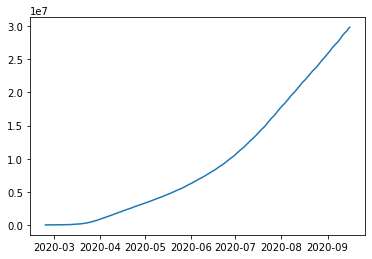

In [9]:
plt.plot(daily_global)

## データ加工（前処理

In [10]:
y=daily_global.values.astype(float)

In [11]:
test_size=3
train_original_data = y[:-test_size]
test_original_data=y[-test_size:]

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))

In [13]:
train_normalized = scaler.fit_transform(train_original_data.reshape(-1,1))
train_normalized.shape

(203, 1)

In [14]:
train_normalized = torch.FloatTensor(train_normalized).view(-1)
window_size=3

## モデル定義

In [15]:
def sequence_creator(input_data, window):
    dataset = []
    data_len = len(input_data)
    for i in range(data_len- window):
        window_fr = input_data[i:i+window]
        label = input_data[i+window:i+window+1]
        dataset.append((window_fr, label))
    return dataset

In [16]:
train_data = sequence_creator(train_normalized,window_size)

In [33]:
class LSTM_Corona(nn.Module):
    def __init__(self, in_size=1, h_size=30, out_size=1):
        super().__init__()
        self.h_size = h_size
        self.lstm = nn.LSTM(in_size, h_size)
        self.fc = nn.Linear(h_size, out_size)
        
        self.hidden = (torch.zeros(1,1, h_size), torch.zeros(1,1,h_size))
        
    def forward(self, sequence_data):
        lstm_out, self.hidden = self.lstm(sequence_data.view(len(sequence_data), 1, -1),self.hidden)
        pred = self.fc(lstm_out.view(len(sequence_data), -1))
        
        return pred[-1]

In [34]:
torch.manual_seed(3)
model = LSTM_Corona()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## 学習する

In [36]:
epochs = 100

for epoch in range(epochs):
    for sequence_in, y_train in train_data:
        y_pred = model(sequence_in)
        loss = criterion(y_pred, y_train)

        
        optimizer .zero_grad()
        model.hidden = (torch.zeros(1,1, model.h_size), torch.zeros(1,1,model.h_size))
        
        loss.backward()
        optimizer.step()
        
    print(f'Epoch {epoch+1} Loss {loss.item():.6f}' )
    

Epoch 1 Loss 0.000000
Epoch 2 Loss 0.000151
Epoch 3 Loss 0.000060
Epoch 4 Loss 0.000042
Epoch 5 Loss 0.000036
Epoch 6 Loss 0.000030
Epoch 7 Loss 0.000024
Epoch 8 Loss 0.000019
Epoch 9 Loss 0.000016
Epoch 10 Loss 0.000014
Epoch 11 Loss 0.000014
Epoch 12 Loss 0.000013
Epoch 13 Loss 0.000013
Epoch 14 Loss 0.000011
Epoch 15 Loss 0.000010
Epoch 16 Loss 0.000007
Epoch 17 Loss 0.000004
Epoch 18 Loss 0.000002
Epoch 19 Loss 0.000000
Epoch 20 Loss 0.000000
Epoch 21 Loss 0.000001
Epoch 22 Loss 0.000002
Epoch 23 Loss 0.000004
Epoch 24 Loss 0.000006
Epoch 25 Loss 0.000008
Epoch 26 Loss 0.000010
Epoch 27 Loss 0.000012
Epoch 28 Loss 0.000014
Epoch 29 Loss 0.000013
Epoch 30 Loss 0.000016
Epoch 31 Loss 0.000016
Epoch 32 Loss 0.000017
Epoch 33 Loss 0.000017
Epoch 34 Loss 0.000018
Epoch 35 Loss 0.000020
Epoch 36 Loss 0.000024
Epoch 37 Loss 0.000029
Epoch 38 Loss 0.000040
Epoch 39 Loss 0.000050
Epoch 40 Loss 0.000064
Epoch 41 Loss 0.000085
Epoch 42 Loss 0.000102
Epoch 43 Loss 0.000122
Epoch 44 Loss 0.0001

## 予測する

In [37]:
test=3

preds = train_normalized[-window_size:].tolist()
model.eval()
for i in range(test):
    sequence = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1,model.h_size), torch.zeros(1, 1, model.h_size))
        preds.append(model(sequence).item())

In [40]:
preductions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1,1))

In [41]:
preductions

array([[29452196.52536226],
       [29688454.60217381],
       [29910448.8468616 ]])

In [47]:
x = np.arange('2020-09-16','2020-09-19', dtype='datetime64[D]').astype('datetime64[D]')
x

array(['2020-09-16', '2020-09-17', '2020-09-18'], dtype='datetime64[D]')

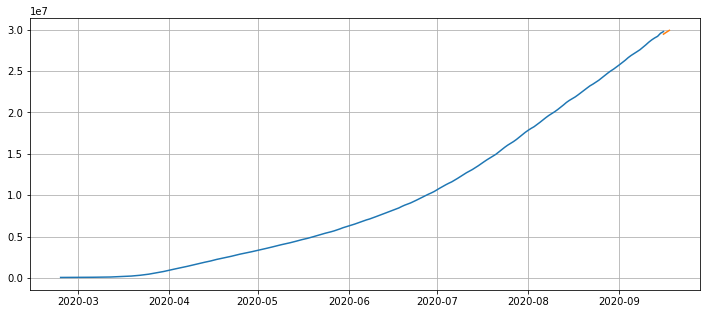

In [50]:
plt.figure(figsize=(12,5))
plt.grid(True)
plt.plot(daily_global)
plt.plot(x,preductions)
plt.show()

## 未来日の予測

In [52]:
epochs = 200
windows_size = 30
unknow = 30

y_normalized = scaler.fit_transform(y.reshape(-1,1))
y_normalized = torch.FloatTensor(y_normalized).view(-1)
full_data = sequence_creator(y_normalized, window_size)

model.train()

LSTM_Corona(
  (lstm): LSTM(1, 30)
  (fc): Linear(in_features=30, out_features=1, bias=True)
)

In [54]:
for epoch in range(epochs):
    for sequence_in, y_train in full_data:
        y_pred = model(sequence_in)
        loss = criterion(y_pred, y_train)
        
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1, 1,model.h_size), torch.zeros(1, 1, model.h_size))
        
        loss.backward()
        optimizer.step()
        
    print(f'Epoch {epoch+1} Loss {loss.item():.6f}' )

Epoch 1 Loss 0.000008
Epoch 2 Loss 0.000015
Epoch 3 Loss 0.000028
Epoch 4 Loss 0.000044
Epoch 5 Loss 0.000063
Epoch 6 Loss 0.000085
Epoch 7 Loss 0.000112
Epoch 8 Loss 0.000140
Epoch 9 Loss 0.000169
Epoch 10 Loss 0.000197
Epoch 11 Loss 0.000223
Epoch 12 Loss 0.000245
Epoch 13 Loss 0.000265
Epoch 14 Loss 0.000281
Epoch 15 Loss 0.000295
Epoch 16 Loss 0.000306
Epoch 17 Loss 0.000315
Epoch 18 Loss 0.000322
Epoch 19 Loss 0.000328
Epoch 20 Loss 0.000333
Epoch 21 Loss 0.000337
Epoch 22 Loss 0.000340
Epoch 23 Loss 0.000343
Epoch 24 Loss 0.000345
Epoch 25 Loss 0.000346
Epoch 26 Loss 0.000347
Epoch 27 Loss 0.000347
Epoch 28 Loss 0.000352
Epoch 29 Loss 0.000356
Epoch 30 Loss 0.000351
Epoch 31 Loss 0.000344
Epoch 32 Loss 0.000344
Epoch 33 Loss 0.000344
Epoch 34 Loss 0.000349
Epoch 35 Loss 0.000347
Epoch 36 Loss 0.000342
Epoch 37 Loss 0.000341
Epoch 38 Loss 0.000340
Epoch 39 Loss 0.000337
Epoch 40 Loss 0.000336
Epoch 41 Loss 0.000334
Epoch 42 Loss 0.000333
Epoch 43 Loss 0.000331
Epoch 44 Loss 0.0003

In [55]:
future=3

preds = y_normalized[-window_size:].tolist()
model.eval()
for i in range(future):
    sequence = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1,model.h_size), torch.zeros(1, 1, model.h_size))
        preds.append(model(sequence).item())

In [56]:
preductions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1,1))

In [59]:
x = np.arange('2020-09-17','2020-09-20', dtype='datetime64[D]').astype('datetime64[D]')
x

array(['2020-09-17', '2020-09-18', '2020-09-19'], dtype='datetime64[D]')

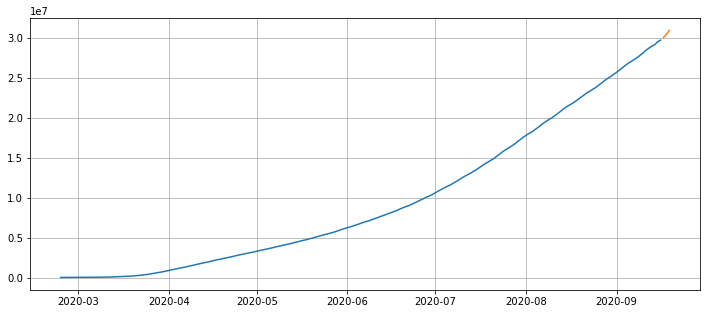

In [60]:
plt.figure(figsize=(12,5))
plt.grid(True)
plt.plot(daily_global)
plt.plot(x,preductions)
plt.show()